# The stability of the global average on different window lengths
This notebook outllines different methods that can be used to de-trend the LongRunMIP and ZECMIP time series.

In [1]:
import nc_time_axis
import warnings

import xarray as xr
import numpy as np
import pandas as pd
from importlib import reload
import string

from scipy.stats import spearmanr
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.ticker as mticker
import matplotlib.gridspec as gridspec 
from matplotlib.axes import Axes
from matplotlib.colors import ListedColormap
import matplotlib.cm as cm
import time

import os
import sys

from numpy.typing import ArrayLike
from typing import Optional, Callable, List, Tuple, Dict

warnings.filterwarnings('ignore')

In [2]:
import constants
from constants import PlotConfig
sys.path.append(constants.MODULE_DIR)
import sn_plotting
import xarray_class_accessors as xca
import utils
import stats
import xarray_extender as xce
import signal_to_noise as sn
import open_ds
from classes import ExperimentTypes, LocationsLatLon
import plotting_functions
logger = utils.get_notebook_logger()

In [3]:
notebook_number='02'

In [4]:
# import dask.distributed as dd
# import tempfile

# tempdir = tempfile.TemporaryDirectory("dask-worker-space")
# dd.Client(local_directory=tempdir.name, memory_limit='16gb')

# Loading Data

In [5]:
experiment_params = constants.EXPERIMENTS_TO_RUN[0]

In [6]:
experiment_zec_da = open_ds.open_mfdataset_nc(os.path.join(constants.ZECMIP_LOCAL_DIR, 'regridded', 'A1'))
picontrol_zec_da = open_ds.open_mfdataset_nc(os.path.join(constants.ZECMIP_LOCAL_DIR, 'regridded', 'picontrol'))

In [7]:
experiment_zec_da

<xarray.DataArray (time: 100, model: 8, lat: 96, lon: 192)>
dask.array<getitem, shape=(100, 8, 96, 192), dtype=float32, chunksize=(100, 1, 96, 192), chunktype=numpy.ndarray>
Coordinates:
  * time      (time) object 0001-12-31 00:00:00 ... 0100-12-31 00:00:00
  * lat       (lat) float64 -88.57 -86.72 -84.86 -83.0 ... 84.86 86.72 88.57
  * lon       (lon) float64 0.0 1.875 3.75 5.625 7.5 ... 352.5 354.4 356.2 358.1
  * model     (model) object 'CESM2' 'CanESM5' ... 'NorESM2-LM' 'UKESM1-0-LL'
    height    float64 2.0
    variable  <U3 'tas'

# Calculation

In [8]:
trend_local_da = stats.trend_fit(experiment_zec_da.chunk({'time':-1}), method='polynomial', order=3)
detrended_local_da = experiment_zec_da - trend_local_da

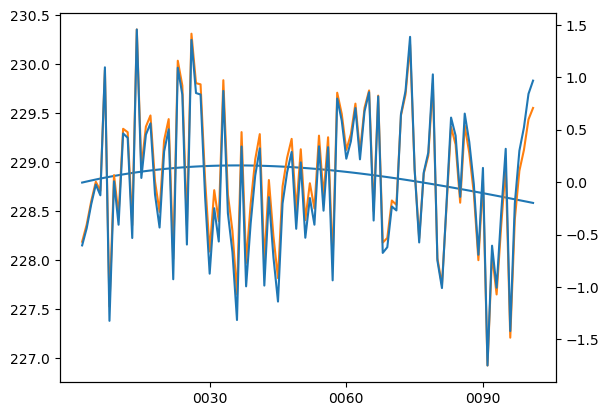

In [9]:
sel_kwargs = dict(model=0,lat=0, lon=0)

fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(trend_local_da.isel(sel_kwargs).time.values,
         trend_local_da.isel(sel_kwargs).values)

ax.plot(experiment_zec_da.isel(sel_kwargs).time.values,
         experiment_zec_da.isel(sel_kwargs).values)

ax2 = ax.twinx()
ax2.plot(detrended_local_da.isel(sel_kwargs).time.values,
         detrended_local_da.isel(sel_kwargs).values)


In [10]:
detrended_local_da = detrended_local_da.persist()

In [11]:
data_dict = {'control':picontrol_zec_da, 'exp':experiment_zec_da}

In [12]:
rolling_noise_types = [True, False]

In [14]:
dir(constants)

['DECK_DIR',
 'EXPERIMENTS_TO_RUN',
 'HEMISPHERE_LAT',
 'IMAGE_SAVE_DIR_INIT',
 'IMAGE_SAVE_DIR_TOP_LEVEL',
 'LONGRUNMIP_CHUNKS',
 'LONGRUNMIP_DIR',
 'LONGRUNMIP_EFFECTIVE_LENGTH',
 'LONGRUNMIP_LENGTH',
 'LONGRUNMIP_MASK_DIR',
 'LONGRUNMIP_MODELS',
 'LONGRUNMIP_MODEL_PARAMS',
 'MODULE_DIR',
 'MULTI_WINDOW_RUN_PARAMS',
 'NamedTuple',
 'PHD_ROOT_DIR',
 'PlotConfig',
 'RANDOM_COLOR_LIST',
 'VARIABLE_INFO',
 'WINDOWS_OF_INTEREST',
 'ZECMIP_DIR',
 'ZECMIP_LOCAL_DIR',
 'ZECMIP_LOCAL_REGRIDDED_DIR',
 'ZECMIP_MODELS',
 'ZECMIP_MODEL_PARAMS',
 'ZECMIP_MULTI_WINDOW_RUN_PARAMS',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 'os',
 'save_kwargs',
 'variables']

In [21]:
SAVE_DIR = os.path.join(constants.ZECMIP_LOCAL_REGRIDDED_DIR, 'signal_to_noise')

In [22]:
already_saved = os.listdir(SAVE_DIR)
already_saved

['A1_polyfit_deg_3.nc',
 'control_rolling_noise_False.nc',
 'control_rolling_noise_True.nc']

In [25]:
for dtype, ds in data_dict.items():
    for rolling_noise in rolling_noise_types:
        print(f'{dtype=}, {rolling_noise=}')
        save_name =  f'{dtype}_rolling_noise_{rolling_noise}.nc'
        print(f' - File to save is {save_name}')

        if save_name not in already_saved: # primitive way of controlling comoplete runs
            print(' -  Running')
            da_for_noise = detrended_local_da if dtype == 'exp' else ds
            sn_ds = sn.multiwindow_signal_to_noise(
            ds, rolling_noise=rolling_noise, da_for_noise=da_for_noise,
                logginglevel='ERROR', return_all=True,
                **constants.ZECMIP_MULTI_WINDOW_RUN_PARAMS)
            sn_ds = sn_ds.persist()
            sn_ds.to_netcdf(os.path.join(SAVE_DIR, save_name))  
        else:
            print(' - Already run')
        count += 1

dtype='control', rolling_noise=True
 - File to save is control_rolling_noise_True.nc
 - Already run
dtype='control', rolling_noise=False
 - File to save is control_rolling_noise_False.nc
 - Already run
dtype='exp', rolling_noise=True
 - File to save is exp_rolling_noise_True.nc
 -  Running
11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35, 37, 39, 41, 43, 45, 47, 49, 
Concatenating objects - PLEASE be patient!
dtype='exp', rolling_noise=False
 - File to save is exp_rolling_noise_False.nc
 -  Running
11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35, 37, 39, 41, 43, 45, 47, 49, 
Concatenating objects - PLEASE be patient!
